In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2023-10-16 07:42:54.081262: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 07:42:54.085394: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 07:42:54.134849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 07:42:54.134914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 07:42:54.134931: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
train_dir = "../dataset/train" #passing the path with training images
test_dir = "../dataset/test"   #passing the path with testing images
SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


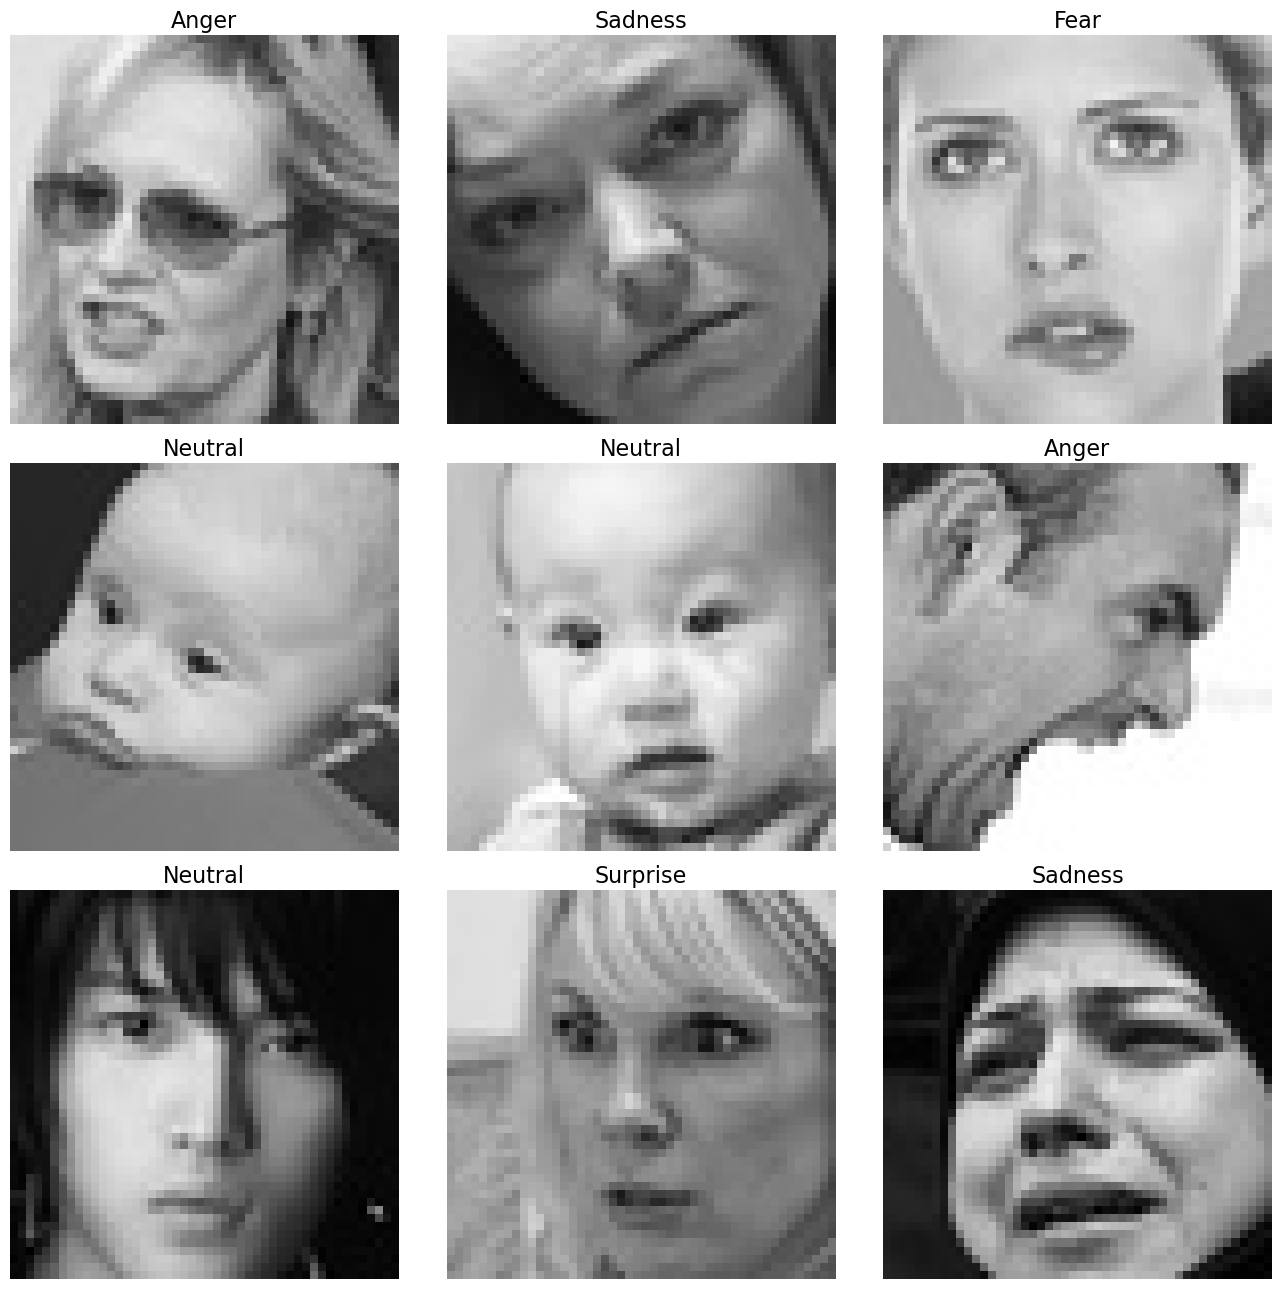

In [4]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [ ]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [6]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [7]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

In [8]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
359/359 [==============================] - 359s 953ms/step - loss: 9.9050 - accuracy: 0.3017 - val_loss: 5.6118 - val_accuracy: 0.1683
Epoch 2/30
359/359 [==============================] - 338s 940ms/step - loss: 3.3781 - accuracy: 0.4339 - val_loss: 2.4494 - val_accuracy: 0.4184
Epoch 3/30
359/359 [==============================] - 335s 933ms/step - loss: 1.8111 - accuracy: 0.4867 - val_loss: 1.5839 - val_accuracy: 0.4715
Epoch 4/30
359/359 [==============================] - 335s 932ms/step - loss: 1.4109 - accuracy: 0.5172 - val_loss: 1.3478 - val_accuracy: 0.5271
Epoch 5/30
359/359 [==============================] - 313s 872ms/step - loss: 1.2786 - accuracy: 0.5467 - val_loss: 1.3955 - val_accuracy: 0.5114
Epoch 6/30
359/359 [==============================] - 332s 925ms/step - loss: 1.2259 - accuracy: 0.5622 - val_loss: 1.2239 - val_accuracy: 0.5611
Epoch 7/30
359/359 [==============================] - 312s 867ms/step - loss: 1.1858 - accuracy: 0.5799 - val_loss: 1.2693 -

In [9]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/20
359/359 [==============================] - 394s 1s/step - loss: 0.9399 - accuracy: 0.6901 - val_loss: 1.0928 - val_accuracy: 0.6184
Epoch 2/20
359/359 [==============================] - 345s 962ms/step - loss: 0.9129 - accuracy: 0.7029 - val_loss: 1.0835 - val_accuracy: 0.6239
Epoch 3/20
359/359 [==============================] - 370s 1s/step - loss: 0.8972 - accuracy: 0.7037 - val_loss: 1.0775 - val_accuracy: 0.6250
Epoch 4/20
359/359 [==============================] - 357s 996ms/step - loss: 0.8812 - accuracy: 0.7101 - val_loss: 1.0768 - val_accuracy: 0.6276
Epoch 5/20
359/359 [==============================] - 317s 883ms/step - loss: 0.8753 - accuracy: 0.7118 - val_loss: 1.0749 - val_accuracy: 0.6262
Epoch 6/20
359/359 [==============================] - 312s 867ms/step - loss: 0.8611 - accuracy: 0.7156 - val_loss: 1.0743 - val_accuracy: 0.6283
Epoch 7/20
359/359 [==============================] - 54388s 152s/step - loss: 0.8543 - accuracy: 0.7196 - val_loss: 1.0735 - val_

AttributeError: 'DataFrame' object has no attribute 'append'

In [11]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 33s 276ms/step


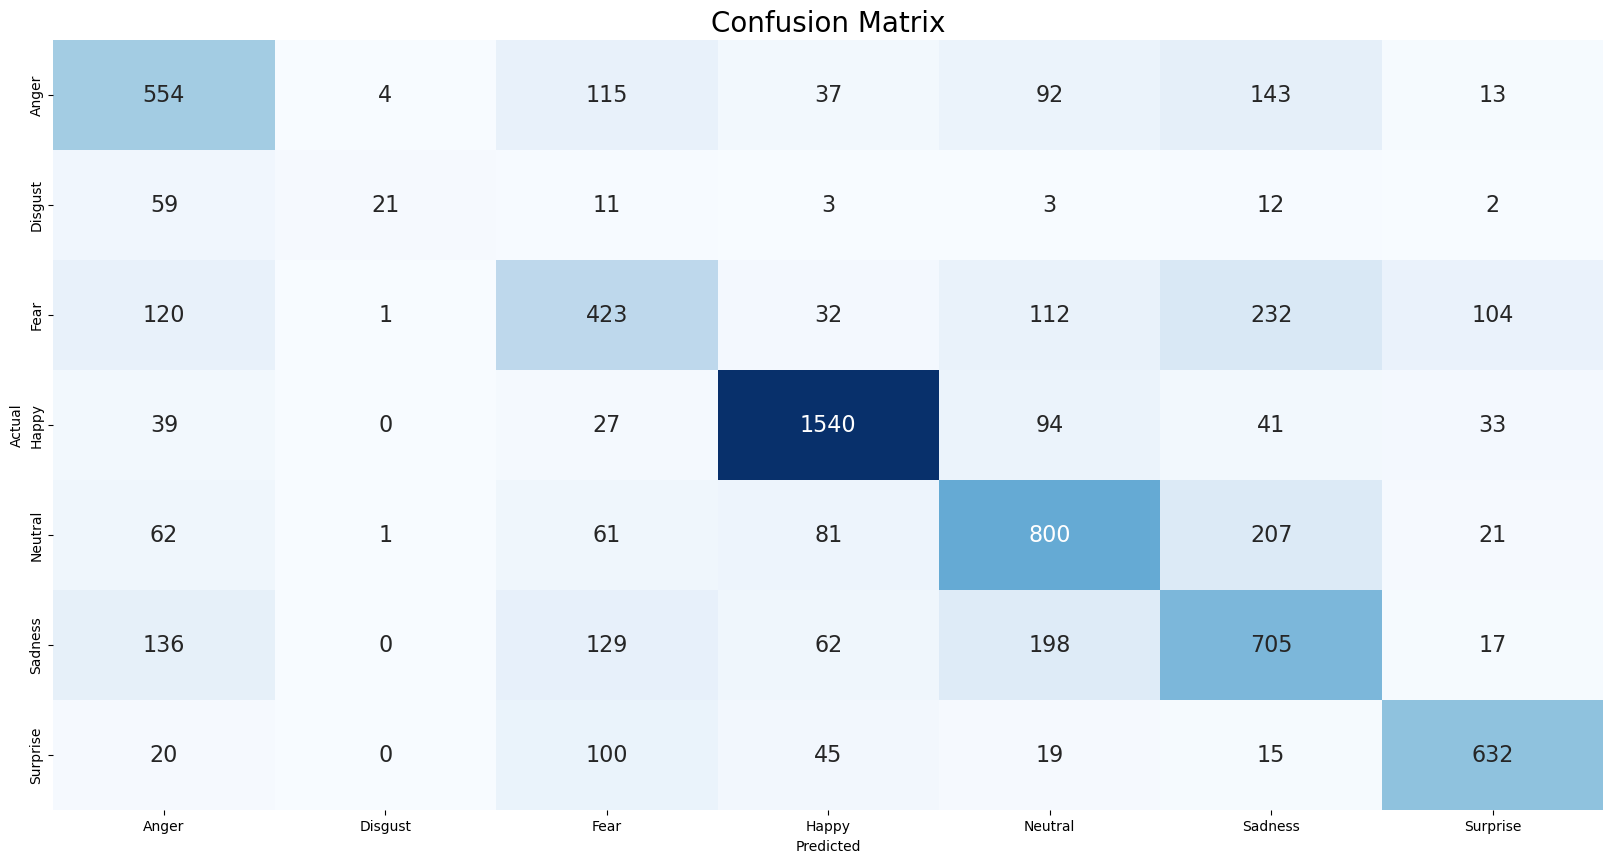

In [12]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [13]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       958
           1       0.78      0.19      0.30       111
           2       0.49      0.41      0.45      1024
           3       0.86      0.87      0.86      1774
           4       0.61      0.65      0.63      1233
           5       0.52      0.57      0.54      1247
           6       0.77      0.76      0.76       831

    accuracy                           0.65      7178
   macro avg       0.65      0.57      0.59      7178
weighted avg       0.65      0.65      0.65      7178



In [14]:
model.save_weights('transfer_model.h5')

In [15]:
model_json = model.to_json()
with open("transfer_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# https://github.com/susantabiswas/realtime-facial-emotion-analyzer
# https://github.com/kaushikjadhav01/Deep-Surveillance-Monitor-Facial-Emotion-Age-Gender-Recognition-System
# https://github.com/travistangvh/emotion-detection-in-real-time/blob/master/src/emotion_webcam_demo.py